# About: Using Challenge's Data

Here, we are going to load data from kaggle source and implement the models of the ``model_training.ipynb`` file.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn import linear_model, metrics
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVC # Support vector classifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from os import walk
import cv2
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
Loading the images with the same color channel (Gray scale)

In [2]:
data_path = "Imagesv2"
_, _, train_filenames = next(walk(data_path + "/Train/"))
_, _, test_filenames = next(walk(data_path + "/Test/"))
train_filenames.sort()
test_filenames.sort()
#train_image = cv2.imread(data_path + "/Train")
train_images = np.array([cv2.imread(data_path + "/Train/" + filename, cv2.IMREAD_GRAYSCALE) for filename in train_filenames])
test_images = np.array([cv2.imread(data_path + "/Test/" + filename, cv2.IMREAD_GRAYSCALE) for filename in test_filenames])

In [3]:
#get labels
labels = pd.read_csv(data_path + "/train_labels.csv")
labels.head()
y = list(labels["Category"])

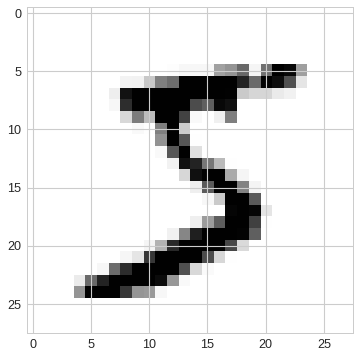

In [86]:
plt.imshow(train_images[0])

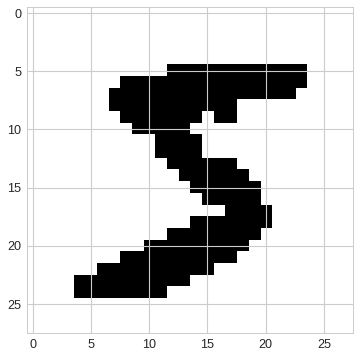

In [89]:
binary_image = train_images[0]
min_value = np.min(binary_image)
binary_image[binary_image == 22] = 0
binary_image[binary_image != 0] = 1
#train_binary_images.append(binary_image)
plt.imshow(binary_image)

## Boolean masking
After noticing that the minimum (maximum) value of train images is 22 (220) and the minimum (maximum) value of the test images is 0 (255) we put the images in a boolean masking that put 0 value when we have 22 as minimum value, and we put 1 when there is a color distinct to dark.

In [4]:
#min pixel from 
train_binary_images = []
test_binary_images = []
for train_image in train_images:
    #we add 0 to dark parts of the image and 1 to non-dark parts
    binary_image = train_image
    min_value = np.min(binary_image)
    binary_image[binary_image == 22] = 0
    binary_image[binary_image != 0] = 1
    train_binary_images.append(binary_image)
    
for test_image in test_images:
    #we add 0 to dark parts of the image and 1 to non-dark parts
    binary_image = test_image
    min_value = np.min(binary_image)
    binary_image[binary_image != 0] = 1
    test_binary_images.append(binary_image)

## Normalization

In [7]:
normalizer = Normalizer()

train_normal_images = []
test_normal_images = []

for train_image in train_images:
    #we add 0 to dark parts of the image and 1 to non-dark parts
    normal_image = normalizer.fit_transform(train_image)
    train_normal_images.append(normal_image)
    
for test_image in test_images:
    #we add 0 to dark parts of the image and 1 to non-dark parts
    normal_image = normalizer.fit_transform(test_image)
    test_normal_images.append(normal_image)

train_normal_images = np.array(train_normal_images)
test_normal_images = np.array(test_normal_images)

## Flattening data

In [5]:
flatten_train = []
for image in train_binary_images:
    flatten_train.append(np.array(image).flatten())    
flatten_test = []
for image in test_binary_images:
    flatten_test.append(np.array(image).flatten())    

flatten_train = np.array(flatten_train)
flatten_test = np.array(flatten_test)

## Scaling

In [5]:
scaler = StandardScaler()
scaled_train_images = scaler.fit_transform(flatten_train)
scaled_test_images = scaler.fit_transform(flatten_test)
scaled_test_images.shape

(10000, 784)

In [25]:
pca = PCA(50)

train_pca = pca.fit_transform(flatten_train)
test_pca = pca.fit_transform(flatten_test)


## Visualizing some digits

7


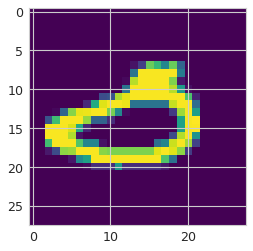

In [8]:
k = 0

print(y_test[k])
plt.imshow(flatten_test[5].reshape((28,28)))
#plt.imshow(flatten_train[0].reshape((28,28)))




# Training some models

## Splitting data into train-test datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(flatten_train, y,
                                                                     test_size = 0.2,
                                                                     random_state = 42)


In [7]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)

In [8]:
lda_predict = lda_model.predict(X_test)
set(lda_predict)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
print(metrics.classification_report(y_test, lda_predict, digits=3))

              precision    recall  f1-score   support

           0      0.786     0.813     0.799      1175
           1      0.836     0.922     0.877      1322
           2      0.565     0.525     0.544      1174
           3      0.544     0.547     0.546      1219
           4      0.623     0.696     0.657      1176
           5      0.520     0.412     0.460      1104
           6      0.544     0.648     0.592      1177
           7      0.789     0.658     0.718      1299
           8      0.588     0.599     0.594      1160
           9      0.629     0.608     0.618      1194

    accuracy                          0.647     12000
   macro avg      0.642     0.643     0.640     12000
weighted avg      0.647     0.647     0.645     12000



In [10]:
kaggle_predict = lda_model.predict(flatten_test)
kaggle_predict

array([9, 6, 8, ..., 9, 3, 6])

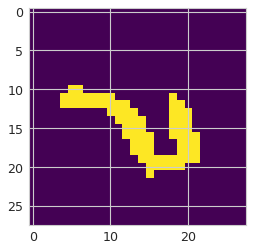

In [36]:
plt.imshow(flatten_test[1].reshape((28,28)))

# Exporting data

In [13]:
from sklearn.pipeline import Pipeline #cross validate different parameters

In [11]:
export_df = pd.DataFrame({"Id":np.array(range(0,10000)),
                          "Category": kaggle_predict})
export_df.to_csv("sub7.csv", index=False)

Best score: 0.8939999999999999
Best PCA: 53


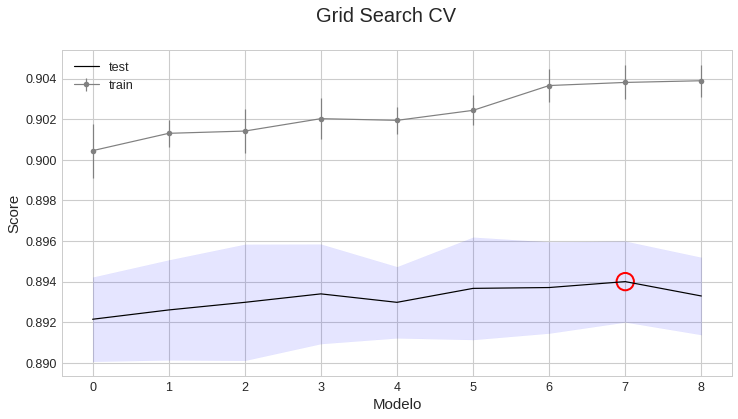

In [14]:
parameters = [{'pca__n_components':[46,47,48,49,50,51,52,53,54]}]
# Realiza Grid Search
cvfolds = 4
pipe =  Pipeline([('pca', PCA()), ('qda', QuadraticDiscriminantAnalysis(store_covariance=True))])
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
#print('Best C:',GS.best_params_["svc__C"])
#print('Best Kernel:',GS.best_params_["svc__kernel"])
print('Best PCA:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1175
           1       0.99      0.94      0.97      1322
           2       0.82      0.94      0.87      1174
           3       0.83      0.86      0.84      1219
           4       0.90      0.91      0.90      1176
           5       0.88      0.88      0.88      1104
           6       0.91      0.88      0.89      1177
           7       0.92      0.88      0.90      1299
           8       0.88      0.87      0.87      1160
           9       0.88      0.87      0.87      1194

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



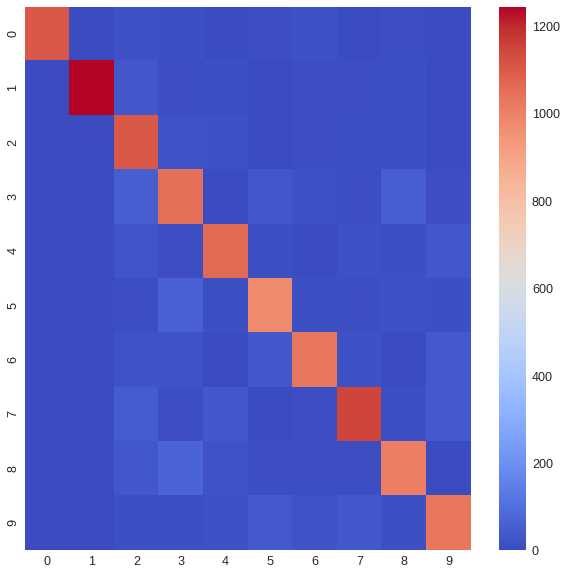

In [15]:
from sklearn import metrics
import seaborn as sns
y_predict = GS.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
fig, axs = plt.subplots(figsize=(10,10))
print(sns.heatmap(confusion_matrix, annot=False, cmap="coolwarm", xticklabels = True, yticklabels = True))
print(metrics.classification_report(y_test, y_predict))

In [16]:
flatten_test_pca = PCA(53).fit_transform(flatten_test)

In [18]:
kaggle_predict = GS.predict(flatten_test)
kaggle_predict

array([2, 2, 8, ..., 5, 2, 2])

In [19]:
set(kaggle_predict)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}